In [1]:
import os
import sys

sys.stderr = open(os.devnull, "w")
    
import logging
logging.getLogger('tensorflow').disabled = True
# Suppress logging warnings
os.environ["GRPC_VERBOSITY"] = "FATAL"
os.environ["GLOG_minloglevel"] = "3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
import keras_tuner as kt

import numpy as np
from matplotlib import pyplot as plt


seed = 42
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.autograph.set_verbosity(1)

os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=" 

tf.get_logger().setLevel("ERROR")
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("absl").setLevel(logging.ERROR)
tf.config.optimizer.set_jit(False)  # Disable XLA to avoid logs

E0000 00:00:1738881598.789230    1319 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738881598.797039    1319 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Blind source separation

This project aims to separate an image, formed as the sum of two images, into its original components.

The two source images, img1 and img2, are drawn from different datasets: MNIST and Fashion-MNIST, respectively.

No preprocessing is allowed. The neural network receives the combined image (img1 + img2) as input and outputs the predicted components (hat_img1,hat_img2).

Performance is evaluated using the mean squared error (MSE) between the predicted and ground-truth images.

Both datasets (MNIST and Fashion-MNIST) are grayscale. For simplicity, all samples are padded to a (32,32) resolution.

In [2]:

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val = train_test_split(mnist_x_train, mnist_y_train, test_size=0.2)
print("mnist train shape:", np.shape(mnist_x_train))
print("mnist val shape:", np.shape(mnist_x_val))
print("mnist test shape:", np.shape(mnist_x_test))


(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
fashion_mnist_x_train, fashion_mnist_x_val, fashion_mnist_y_train, fashion_mnist_y_val = train_test_split(fashion_mnist_x_train, fashion_mnist_y_train, test_size=0.2)
print("fashion mnist train shape:", np.shape(fashion_mnist_x_train))
print("fashion mnist val shape:", np.shape(fashion_mnist_x_val))
print("fashion mnist test shape:", np.shape(fashion_mnist_x_test))

#normalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_val = np.pad(mnist_x_val, ((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.

fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_val = np.pad(fashion_mnist_x_val,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

mnist train shape: (48000, 28, 28)
mnist val shape: (12000, 28, 28)
mnist test shape: (10000, 28, 28)
fashion mnist train shape: (48000, 28, 28)
fashion mnist val shape: (12000, 28, 28)
fashion mnist test shape: (10000, 28, 28)
(48000, 32, 32)


In [3]:
print(np.shape(mnist_x_train))

(48000, 32, 32)


Here is a simple datagenerator.

In [4]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Let us define a generator with batchsize=1 and let's test it.

In [5]:
onegen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

Let us look at some input-output pairs

In [6]:
def show_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

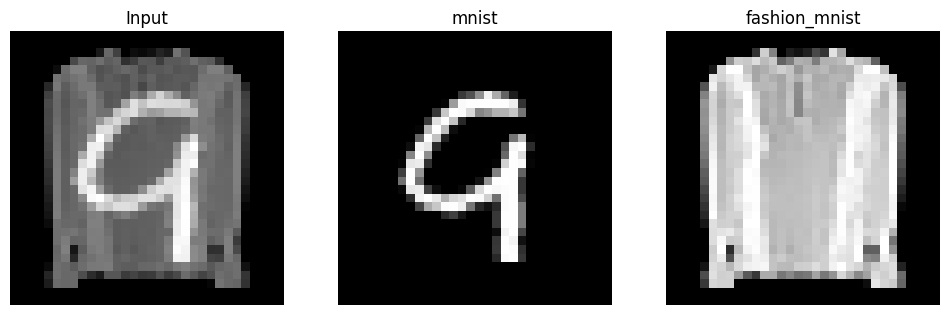

In [7]:
x,(y1,y2)=next(onegen)
show_images(x[0],y1[0],y2[0])

# Model evaluation

Let us define the test generator.

In [8]:
testgen = datagenerator(mnist_x_test,fashion_mnist_x_test,5000)

eval_samples_x, (eval_samples_y1, eval_sample2) = next(testgen)

We test a model returning twice the input image. You will need to replace it with your own predictive model.

In [9]:
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class MyHyperModel(kt.HyperModel):
    def __init__(self, input_shape=(32, 32, 1), total_modules=3, conv_layers_per_module=2):
        """
        Initializes the hypermodel with fixed architectural parameters.
        
        Args:
            input_shape: Shape of the input images.
            total_modules: Total number of encoder modules (including the bottleneck).
            conv_layers_per_module: Number of convolution layers in each module.
        """
        self.input_shape = input_shape
        self.total_modules = total_modules
        self.conv_layers_per_module = conv_layers_per_module

    def encoder_module(self, x, module_idx, filters, activation_fn):
        """
        Applies a block of convolutional operations and downsamples the feature maps.
        
        Args:
            x: Input tensor.
            module_idx: Current module index.
            filters: Number of convolution filters.
            conv_layers: Number of convolution layers to apply.
            skip_list: List to store outputs for skip connections.
            activation_fn: Activation function to be used.
        
        Returns:
            A tuple (output_tensor, updated_filters).
        """
        for _ in range(self.conv_layers_per_module):
            x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation(activation_fn)(x)
        
        # Save output for skip connection if not in the bottleneck module.
        if module_idx < self.total_modules - 1:
            self.skip_connections.append(x)
            x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
            filters *= 2
        return x, filters
    
    def decoder_module(self, x, module_idx, filters, activation_fn):
        """
        Upsamples the input, concatenates with the corresponding skip connection,
        and applies a block of convolutional operations.
        
        Args:
            x: Input tensor from the previous layer.
            module_idx: Current decoder module index.
            filters: Current number of filters.
            conv_layers: Number of convolution layers to apply.
            skip_list: List containing encoder outputs for skip connections.
            activation_fn: Activation function to be used.
        
        Returns:
            A tuple (output_tensor, updated_filters).
        """
        filters //= 2
        x = layers.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same')(x)
        # Use the last stored skip connection
        x = layers.concatenate([x, self.skip_connections.pop()])
        
        # Process with a convolutional block
        for _ in range(self.conv_layers_per_module):
            x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation(activation_fn)(x)
        return x, filters

    def build(self, hp):
        """
        Constructs and compiles the model based on hyperparameters defined via Keras Tuner.
        
        Hyperparameters tuned:
            - initial number of filters
            - activation function
            - learning rate
        
        Returns:
            A compiled Keras model with two outputs (each 32x32x1).
        """
        # Hyperparameter definitions
        init_filters = hp.Choice('initial_filters', values=[32, 64, 128], default=128)
        activation_fn = hp.Choice('activation_function', values=['relu', 'sigmoid', 'tanh', 'leaky_relu'], default='relu')
        lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # Input layer
        inputs = layers.Input(shape=self.input_shape)
        self.skip_connections = []
        x = inputs
        filters = init_filters

        # Encoder path
        for module in range(self.total_modules):
            x, filters = self.encoder_module(x, module, filters, activation_fn)

        # Decoder path (one fewer module than encoder)
        for module in range(self.total_modules - 1):
            x, filters = self.decoder_module(x, module, filters, activation_fn)

        # # Two separate output layers (1x1 convolutions) for two predictions
        output1 = layers.Conv2D(1, kernel_size=1, activation=activation_fn)(x)
        output1 = layers.Reshape((32, 32), name="MNIST_output")(output1)  # Ensure the final shape is (32, 32)
        output2 = layers.Conv2D(1, kernel_size=1, activation=activation_fn)(x)
        output2 = layers.Reshape((32, 32), name="Fashion_MNIST_output")(output2)  # Ensure the final shape is (32, 32)

        model = models.Model(inputs=inputs, outputs=[output1, output2])
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mse'])
        return model

# Instantiate the hypermodel.
hypermodel = MyHyperModel(input_shape=(32, 32, 1), total_modules=3, conv_layers_per_module=2)

In [10]:
# Set up the Keras Tuner using RandomSearch.
tuner = kt.RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='tuner_directory',
    project_name='model_tuning_project',
    seed=seed
)

Reloading Tuner from tuner_directory/model_tuning_project/tuner0.json


In [11]:
batch_size = 32
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batch_size)
val_generator = datagenerator(mnist_x_val, fashion_mnist_x_val, batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

tuner.search(
    train_generator,
    epochs=10,  # Keep low initially, increase later
    steps_per_epoch=len(mnist_x_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(mnist_x_val) // batch_size,
    callbacks=[early_stop, reduce_lr]
)

In [12]:
import json

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# change learning rate to 0.01 because the number of epochs is increased
# best_hps.values['learning_rate'] = 0.01

print(f"""
Best Initial Filters: {best_hps.get('initial_filters')}
Best Activation Function: {best_hps.get('activation_function')}
Best Learning Rate: {best_hps.get('learning_rate')}
""")

batch_size = 32
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batch_size)
val_generator = datagenerator(mnist_x_val, fashion_mnist_x_val, batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Build best model
best_model = tuner.hypermodel.build(best_hps)

# Train best model with more epochs
history = best_model.fit(
    train_generator,
    epochs=100,  # Train longer on best configuration
    steps_per_epoch=len(mnist_x_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(mnist_x_val) // batch_size,
    callbacks=[early_stop, reduce_lr]
)

best_model.save("my_best_model.h5")

# After training your model and obtaining the history:
with open("training_history.json", "w") as f:
    json.dump(history.history, f)


Best Initial Filters: 128
Best Activation Function: relu
Best Learning Rate: 0.001

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 181s 106ms/step - Fashion_MNIST_output_loss: 0.0141 - Fashion_MNIST_output_mse: 0.0141 - MNIST_output_loss: 0.0329 - MNIST_output_mse: 0.0329 - loss: 0.0469 - val_Fashion_MNIST_output_loss: 0.0025 - val_Fashion_MNIST_output_mse: 0.0025 - val_MNIST_output_loss: 0.0022 - val_MNIST_output_mse: 0.0022 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 162s 108ms/step - Fashion_MNIST_output_loss: 0.0023 - Fashion_MNIST_output_mse: 0.0023 - MNIST_output_loss: 0.0019 - MNIST_output_mse: 0.0019 - loss: 0.0041 - val_Fashion_MNIST_output_loss: 0.0014 - val_Fashion_MNIST_output_mse: 0.0014 - val_MNIST_output_loss: 0.0014 - val_MNIST_output_mse: 0.0014 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 163s 108ms/step - Fashion_MNIST_output_loss: 0.0018 - Fashion_MNIST_output_mse: 0.0018 - MNIST_output_

I0000 00:00:1738866932.226328   29763 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4701 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:06:00.0, compute capability: 6.1
I0000 00:00:1738866941.341032   30078 service.cc:148] XLA service 0x7fea8c00a0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738866941.341219   30078 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
I0000 00:00:1738866943.030451   30078 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1738866956.549192   30078 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [26]:
print(best_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,280 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    147,584 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    590,080 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 256) │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 8,272,132 (31.56 MB)

 Trainable params: 8,267,010 (31.54 MB)

 Non-trainable params: 5,120 (20.00 KB)

 Optimizer params: 2 (12.00 B)

None


In [12]:
def eval_model(model):
  x, (y1,y2) = next(testgen)
# 
  # use model.predict to get predictions. Here we just call model
  pred1, pred2 = model.predict(x)

  # return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2) / 2)
  return (np.mean((pred1 - y1) ** 2) + np.mean((pred2 - y2) ** 2)) / 2

In [17]:
from tensorflow.keras.models import load_model
# Map the key 'mse' to the appropriate function
best_model = load_model("my_best_model.h5", custom_objects={
    'mse': lambda y_true, y_pred: tf.keras.losses.MeanSquaredError()(y_true, y_pred)
})

repeat_eval = 30
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(best_model))
print("mse = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 2

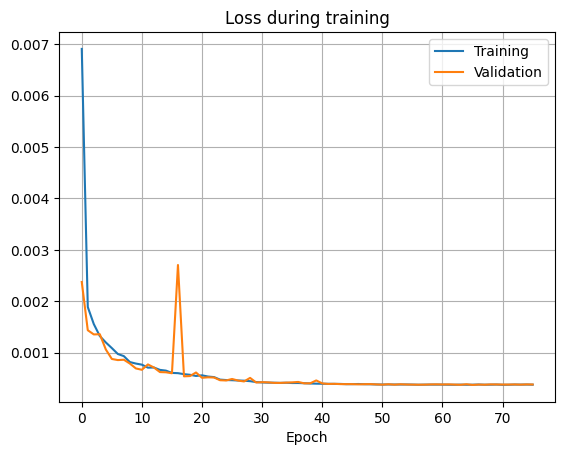

In [24]:
import json
with open("training_history.json", "r") as f:
    history = json.load(f)

def display_history(history):
    if not isinstance(history, dict):
        history = history.history
    
    mse_training = history['loss']
    # acc_training = history.history['accuracy']

    mse_val = history['val_loss']
    # acc_val = history.history['val_accuracy']
    
    mse_fashion = history['Fashion_MNIST_output_loss']
    mse_mnist = history['MNIST_output_loss']
    mse_mean = [(a+b)/2 for a,b in zip(mse_fashion, mse_mnist)]
    
    mse_val_fashion = history['val_Fashion_MNIST_output_loss']
    mse_val_mnist = history['val_MNIST_output_loss']
    mse_val_mean = [(a+b)/2 for a,b in zip(mse_val_fashion, mse_val_mnist)]
    # Visualize the behavior of the loss
    # plt.plot(mse_training)
    # plt.plot(mse_val)
    plt.plot(mse_mean)
    plt.plot(mse_val_mean)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # # and of the accuracy
    # plt.plot(acc_training)
    # plt.plot(acc_val)
    # plt.grid()
    # plt.title('Accuracy during training')
    # plt.xlabel('Epoch')
    # plt.legend(['Training', 'Validation'])
    # plt.show()

# print(history.model.summary())
display_history(history)

In [16]:
batch_visual_gen = 8
visual_test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batch_visual_gen)

def visual_test(generator, model, n_images=1):
    x_test, y_test = next(generator)

    for i in range(n_images):
        print(f'\n --------- IMAGE {i+1} --------- \n')
        # Create the grid
        show_images(x_test[i], y_test[0][i], y_test[1][i])
        
        # Get the prediction
        pred1, pred2 = model.predict(x_test[i][np.newaxis, ...])
        
        # Display the prediction
        print('Predictions:')
        show_images(x_test[i], pred1[0], pred2[0])
        print('\n')
        
        plt.show()
        
visual_test(visual_test_generator, model, n_images=1)

NameError: name 'model' is not defined

# What to deliver
As usual, you are supposed to deliver a single notebook that is supposed to run on colab. The notebook should be adequately commented, contain a full trace of the training, the computation of the mse in the form specified above and a few examples.

Good Work!